In [1]:
import pywt
# (cA, cD) = pywt.dwt([1, 2, 3, 4, 5, 6], 'db1')
# ([2.12132034 4.94974747 7.77817459], [-0.70710678 -0.70710678 -0.70710678])
# https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from matplotlib import style
# style.use('ggplot')

[[5.28208910e-05 1.85689889e-04 4.86560170e-05 5.20357860e-05]
 [4.76967540e-05 1.81193464e-04 5.04292550e-05 4.91077080e-05]
 [4.92557880e-05 1.81288458e-04 4.37470150e-05 4.57139690e-05]
 [4.59905710e-05 1.79178081e-04 3.82270660e-05 3.87579200e-05]
 [4.25474720e-05 1.71777792e-04 4.40329310e-05 4.24394380e-05]
 [4.06345350e-05 1.64050609e-04 3.94154340e-05 3.68524340e-05]
 [3.17627560e-05 1.57933682e-04 3.18000090e-05 2.73585320e-05]
 [2.28025020e-05 1.51385553e-04 2.84528360e-05 1.71922150e-05]
 [2.47480350e-05 1.50495209e-04 2.25771220e-05 2.05161050e-05]
 [2.37878410e-05 1.48945488e-04 2.27326530e-05 1.83144580e-05]
 [2.11950390e-05 1.43660232e-04 1.90930440e-05 1.24452640e-05]
 [1.76839530e-05 1.44200400e-04 2.02069060e-05 8.78702800e-06]
 [1.90390270e-05 1.46069564e-04 2.13682650e-05 6.86757300e-06]
 [1.90166760e-05 1.44448131e-04 1.90241260e-05 8.61380200e-06]
 [1.71717260e-05 1.42258592e-04 1.96862970e-05 1.01067130e-05]
 [1.85649840e-05 1.42875127e-04 1.86376270e-05 8.645467

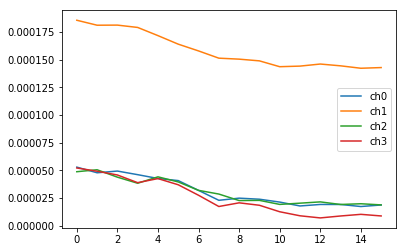

In [2]:
df = pd.read_csv("filtered_pasta/0.csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
df.loc[0:15].plot()
print(df.loc[0:15].values)
print(df.loc[0:15]['ch0'])
# wt = dwt(df.loc[15:29])
# plt.plot(wt)
# plt.show()
# df = pd.read_csv("filtered_pasta/0.csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
# arr = df.loc[0:14].div(0.00001)["ch0"].values
# arr = np.append(arr, arr)
# print(arr)
# # dwt(df.loc[0:14].values)
# print(raw(df.loc[0:14]))

In [3]:
def wt(segment):
    # featureSize = 8
    return pywt.wavedec(segment["ch0"], 'db1', level=3)[2]

def dwt(segment):
    # featureSize = 16
    coeffs = pywt.dwt2(segment.values, 'haar')
    cA, (cH, cV, cD) = coeffs
    res = cA.flatten()
    return res

def raw(segment):
    segment = segment.div(0.00001)
    # featureSize = 4 * batchSize + 16
    res = segment["ch0"].values
    res = np.append(res, segment["ch1"].values)
    res = np.append(res, segment["ch2"].values)
    res = np.append(res, segment["ch3"].values)
    res = np.append(res, dwt(segment))
    return res

featureSize = 76
def getFeature(segment):
    return raw(segment)

def featuresFromFile(fileName, fileNum):
    global featureSize
    batch = 15
    df = pd.read_csv("filtered_" + fileName + "/" + str(fileNum) + ".csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
    pickups = np.empty(shape=[0,featureSize])
    putdowns = np.empty(shape=[0,featureSize])

    rows = df.shape[0]
    turns = rows / batch
    turns -= turns % 2
    rows = turns * batch
    r = 0
    while r < rows:
        # pick-up
        pickups = np.vstack((pickups, getFeature(df.loc[r:r+batch-1])))
        r += batch
        # put-down
        putdowns = np.vstack((putdowns, getFeature(df.loc[r:r+batch-1])))
        r += batch
    return (pickups, putdowns)

def labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, fileName, fileNum, label):
    (pickups, putdowns) = featuresFromFile(fileName, fileNum)
    # register features
    pickupFeatures = np.vstack((pickupFeatures, pickups))
    putdownFeatures = np.vstack((putdownFeatures, putdowns))
    # register labels
    pickupLabels = np.hstack((pickupLabels, np.full((1, pickups.shape[0]), label)))
    putdownLabels = np.hstack((putdownLabels, np.full((1, putdowns.shape[0]), label + 1)))
    return (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels)

def trainModels(features, labels):
    # features
    X = features
    # labels
    y = labels.flatten()
    clf = svm.SVC(C=1, kernel='poly', coef0=1.0, probability=True, tol=1e-5)
    clf.fit(X, y)
    return clf

def predict(pickupModel, putdownModel, fileName, fileRange, answerLabel):
    pickupResult = np.array([], dtype=int)
    putdownResult = np.array([], dtype=int)
    pickupCorrect = 0
    putdownCorrect = 0
    for fileNum in fileRange:
        (pickups, putdowns) = featuresFromFile(fileName, fileNum)
        pickupResult = np.append(pickupResult, pickupModel.predict(pickups))
        putdownResult = np.append(putdownResult, putdownModel.predict(putdowns))
    for label in pickupResult:
        if label == answerLabel:
            pickupCorrect += 1
    for label in putdownResult:
            if label == (answerLabel + 1):
                putdownCorrect += 1
    print(pickupResult)
    print(putdownResult)
    print("{0:.2f}".format(100.0 * pickupCorrect / pickupResult.size) + '%')
    print("{0:.2f}".format(100.0 * putdownCorrect / putdownResult.size) + '%')

In [45]:
# 1: pick up chocolate
# 2: put down chocolate
# 3: pick up peach
# 4: put down peach
# 5: pick up pasta
# 6: put down pasta

totalFiles = 10
predictNo = 8

pickupFeatures = np.empty(shape=[0, featureSize])
pickupLabels = np.empty(shape=[1, 0],dtype=int)
putdownFeatures = np.empty(shape=[0, featureSize])
putdownLabels = np.empty(shape=[1, 0],dtype=int)

for fileNum in range(predictNo):
    (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, "chocolate", fileNum, 1)
#     (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, "peach", fileNum, 3)
    (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, "pasta", fileNum, 5)

pickupModel = trainModels(pickupFeatures, pickupLabels)
putdownModel = trainModels(putdownFeatures, putdownLabels)

predict(pickupModel, putdownModel, "chocolate", range(predictNo, totalFiles), 1)
# predict(pickupModel, putdownModel, "peach", range(predictNo, totalFiles), 3)
predict(pickupModel, putdownModel, "pasta", range(predictNo, totalFiles), 5)

[1 1 1 1 1 5 1 1 1 5 1 5 1 1 1 1 1 1]
[2 2 6 6 2 6 2 2 2 2 2 2 2 6 2 2 6 2]
83.33%
72.22%
[1 5 5 1 1 1 5 1 5 5 5 1 5 5 1 5 5 5 5 5 5 5]
[6 6 2 2 6 6 2 6 6 6 6 6 2 2 6 6 2 2 6 2 6 6]
31.82%
36.36%
[5 5 5 1 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5]
[2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
90.91%
95.45%


/Users/allenh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/allenh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
# 124
# 61.36%
# 56.82%
# 31.03%
# 22.41%
# 87.93%
# 82.76%

# 76
# 61.36%
# 56.82%
# 31.03%
# 25.86%
# 87.93%
# 84.48%

# 60
# 61.36%
# 50.00%
# 31.03%
# 24.14%
# 89.66%
# 82.76%

# 8/10
# 72.22%
# 55.56%
# 77.27%
# 68.18%
# 86.36%
# 86.36%
